In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
z_dim = 2
batch_size = 100
nb_steps = 50000

In [3]:
def render_images(np_x):
    np_x = np_x.reshape((10,10,28,28))
    np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.title('Generation')
    plt.show()

In [4]:
def encoder(x, z_dim=20, reuse=False):
    with tf.variable_scope("encoder", reuse=reuse):
        l1 = tf.layers.dense(x, 512, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(l2, z_dim, activation=None)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(l2, z_dim, activation=None))
        return mu, sigma

In [5]:
def decoder(z, z_dim=20, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        l1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 512, activation=tf.nn.relu)
        x_hat = tf.layers.dense(l2, 784, activation=tf.nn.sigmoid)
        return x_hat

In [6]:
x = tf.placeholder(tf.float32, [batch_size, 784])
mu, sigma = encoder(x, z_dim=z_dim)
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
x_hat = decoder(z)

In [7]:
loglikelihood = tf.reduce_mean(tf.reduce_sum(x * tf.log(x_hat + 1e-8) + (1 - x) * tf.log(1 - x_hat + 1e-8), [1]))
kl = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, [1]))
ELBO = loglikelihood - kl
loss = -ELBO

In [8]:
optim_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
init_op = tf.global_variables_initializer()

In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [11]:
sess.run(init_op)
start_time = time.time()
for stp in range(1, nb_steps+1):
    x_np, _ = mnist.train.next_batch(batch_size)
    _, loss_np, rec_np, kl_np = sess.run([optim_op, loss, loglikelihood, kl], feed_dict={x: x_np})
    if stp % 5000 == 0:
        end_time = time.time()
        print('Step: {:d} in {:.2f}s :: Loss: {:.3f} => Recons.: {:.3f}, KL: {:.3f}'.format(stp, end_time - start_time, loss_np, -rec_np, kl_np))
        start_time = end_time

Step: 5000 in 16.84s :: Loss: 157.821 => Recons.: 151.548, KL: 6.272
Step: 10000 in 16.60s :: Loss: 141.679 => Recons.: 134.935, KL: 6.745
Step: 15000 in 16.75s :: Loss: 140.901 => Recons.: 133.956, KL: 6.945
Step: 20000 in 16.45s :: Loss: 139.013 => Recons.: 132.324, KL: 6.690
Step: 25000 in 16.40s :: Loss: 136.791 => Recons.: 129.779, KL: 7.013
Step: 30000 in 16.65s :: Loss: 137.499 => Recons.: 130.429, KL: 7.070
Step: 35000 in 16.53s :: Loss: 129.830 => Recons.: 122.661, KL: 7.169
Step: 40000 in 16.63s :: Loss: 135.151 => Recons.: 127.973, KL: 7.178
Step: 45000 in 16.71s :: Loss: 134.383 => Recons.: 126.931, KL: 7.451
Step: 50000 in 16.68s :: Loss: 136.584 => Recons.: 129.392, KL: 7.192


In [12]:
total_loss = 0.
total_rec_loss = 0.
n_batches = 0.
zs = []
for i in range(0, mnist.test.images.shape[0], batch_size):
    x_np = mnist.test.images[i:(i+batch_size)]
    z_np, loss_np, rec_np = sess.run([z, loss, loglikelihood], feed_dict={x: x_np})
    total_loss += loss_np
    total_rec_loss += rec_np
    n_batches += 1
    zs.append(z_np)
avg_loss = total_loss/n_batches
avg_rec_loss = total_rec_loss/n_batches
print(avg_loss, -avg_rec_loss)

138.5255584716797 131.3198072052002


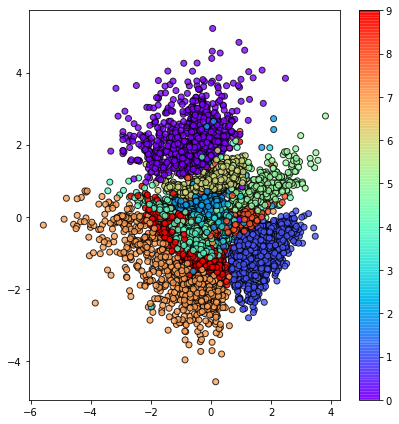

In [13]:
if z_dim == 2:
    z_test = np.vstack(zs)
    y_test = np.argmax(mnist.test.labels, axis=1)
    plt.figure(figsize=(6, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, alpha=0.8, cmap='rainbow', edgecolor='k')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('../report/imgs/vae-latentspace.png', dpi=300, bbox_inches='tight')